<a href="https://colab.research.google.com/github/myazdani/number-guessing/blob/master/number_guessing_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference for online logistic regerssion learning rule: https://courses.cs.washington.edu/courses/cse547/16sp/slides/logistic-SGD.pdf



In [1]:
import torch
from torch import nn
import numpy as np
from torch import optim


In [2]:
import random
import matplotlib.pyplot as plt

In [3]:
class RandomDecision:

    def decision(self, shown_number=0):
        self.prediction = bool(random.randint(0,1))
        return self.prediction

    def update_rule(self, actual):
        pass


class AlwaysTrue:

    def decision(self, shown_number=0):
        self.prediction = True
        return self.prediction

    def update_rule(self, actual):
        pass        

In [4]:
class LinearDecision:
    def __init__(self, lr = 0.1):
        self.w0 = torch.randn(1)
        self.w1 = torch.randn(1)
        self.sigmoid = nn.Sigmoid()
        self.lr = lr
        self.t = 1
    
    def decision(self, shown_number):
        self.shown_number = shown_number
        self.prediction = self.sigmoid(self.shown_number*self.w1 + self.w0)
        decision = bool(self.prediction > 0.5)
        return decision

    def update_rule(self, actual):
        delta = actual - self.prediction
        eta = self.lr/(1+np.log(self.t))
        self.w0 = self.w0 + eta*delta
        self.w1 = self.w1 + eta*self.shown_number*delta
        self.t+=1
        

In [5]:
class LinearMLPDecision:
    def __init__(self, lr = 0.1):
        self.model = nn.Sequential(
            nn.Linear(1, 1), nn.Sigmoid()
        )
        self.lr = lr
        self.t = 1
        self.loss = nn.BCELoss()
        self.sgd = optim.SGD(self.model.parameters(), lr=self.lr)


    def decision(self, shown_number):
        self.shown_number = shown_number
        self.prediction = self.model(shown_number.view(1,1))
        decision = bool(self.prediction.item() > 0.5)
        return decision

    def update_rule(self, actual):
        eta = self.lr/(1+np.log(self.t))
        for g in self.sgd.param_groups:
            g['lr'] = eta
        loss = self.loss(self.prediction, actual.view(1,1))
        self.sgd.zero_grad()
        loss.backward()
        self.sgd.step()
        self.t+=1
        

In [6]:
class MLPDecision:
    def __init__(self, lr = 0.1):
        self.model = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(), 
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self.lr = lr
        self.t = 1
        self.loss = nn.BCELoss()
        self.sgd = optim.Adam(self.model.parameters(), lr=self.lr)


    def decision(self, shown_number):
        self.shown_number = shown_number
        self.prediction = self.model(shown_number.view(1,1))
        decision = bool(self.prediction.item() > 0.5)
        return decision

    def update_rule(self, actual):
        # eta = self.lr/(1+np.log(self.t))
        # for g in self.sgd.param_groups:
        #     g['lr'] = eta
        loss = self.loss(self.prediction, actual.view(1,1))
        self.sgd.zero_grad()
        loss.backward()
        self.sgd.step()
        self.t+=1
        

In [7]:
from sklearn import datasets

In [10]:
random_agent = RandomDecision()
true_agent = AlwaysTrue()
#linear_agent = LinearMLPDecision(0.9)
linear_agent = LinearDecision(0.9)
mlp_agent = MLPDecision(1e-3)
random_rewards = []
always_true_rewards = []
linear_rewards = []
mlp_rewards = []


def get_reward(hidden_number_is_bigger, actual):
    if hidden_number_is_bigger == actual:
        return 1
    else:
        return 0


for _ in range(10000):
    selected_numbers = 3*torch.randn(2)+5
    #selected_numbers = torch.from_numpy(datasets.make_blobs(n_samples=1,)[0]).type(torch.float32)[0]
    #selected_numbers = 2e15*(torch.rand(2)-.5)
    coin_flip = random.randint(0,1)
    shown_number = selected_numbers[coin_flip]
    hidden_number = selected_numbers[~coin_flip]

    actual = hidden_number > shown_number

    ## random strategy
    hidden_number_is_bigger = random_agent.decision(shown_number)
    random_rewards.append(get_reward(hidden_number_is_bigger, actual))

    ## always return true strategy
    hidden_number_is_bigger = true_agent.decision(shown_number)
    always_true_rewards.append(get_reward(hidden_number_is_bigger, actual))    

    # linear strategy
    hidden_number_is_bigger = linear_agent.decision(shown_number)
    linear_agent.update_rule(actual.type(torch.float32))    
    linear_rewards.append(get_reward(hidden_number_is_bigger, actual))

    # mlp strategy
    hidden_number_is_bigger = mlp_agent.decision(shown_number)
    mlp_agent.update_rule(actual.type(torch.float32))    
    mlp_rewards.append(get_reward(hidden_number_is_bigger, actual))


    


optimal_rewards = np.cumsum(np.ones_like(linear_rewards))

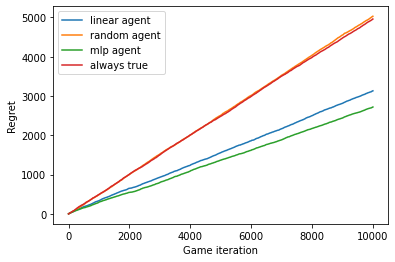

In [16]:

plt.plot(optimal_rewards - np.cumsum(np.array(linear_rewards)), label = "linear agent")
plt.plot(optimal_rewards- np.cumsum(np.array(random_rewards)), label = "random agent")
plt.plot(optimal_rewards- np.cumsum(np.array(mlp_rewards)), label = "mlp agent")
plt.plot(optimal_rewards- np.cumsum(np.array(always_true_rewards)), label = "always true")
plt.ylabel("Regret")
plt.xlabel("Game iteration")
plt.legend();

In [ ]:
naive_agent = NaiveDecision()
true_agent = AlwaysTrue()
#linear_agent = LinearMLPDecision(0.9)
linear_agent = LinearDecision(0.9)
mlp_agent = MLPDecision(1e-3)
naive_rewards = []
always_true_rewards = []
linear_rewards = []
mlp_rewards = []


def get_reward(hidden_number_is_bigger, actual):
    if hidden_number_is_bigger == actual:
        return 1
    else:
        return 0

mu = 0
sigma = 0
for i in range(10000):
    selected_numbers = 3*torch.randn(2)+1000
    #selected_numbers = torch.from_numpy(datasets.make_blobs(n_samples=1,)[0]).type(torch.float32)[0]
    #selected_numbers = 2e15*(torch.rand(2)-.5)
    coin_flip = random.randint(0,1)
    shown_number = selected_numbers[coin_flip]
    hidden_number = selected_numbers[~coin_flip]

    actual = hidden_number > shown_number

    ## naive strategy
    hidden_number_is_bigger = naive_agent.decision(shown_number)
    naive_rewards.append(get_reward(hidden_number_is_bigger, actual))

    ## always return true strategy
    hidden_number_is_bigger = true_agent.decision(shown_number)
    always_true_rewards.append(get_reward(hidden_number_is_bigger, actual))    

    # linear strategy
    mu = (i*mu + shown_number)/(i+1)
    sigma = (i*sigma + (shown_number-mu)**2)/(i+1)
    if i > 2:
        z = (shown_number-mu)/sigma**.5
    else:
        z = shown_number
    hidden_number_is_bigger = linear_agent.decision(z)
    linear_agent.update_rule(actual.type(torch.float32))    
    linear_rewards.append(get_reward(hidden_number_is_bigger, actual))

    # mlp strategy
    hidden_number_is_bigger = mlp_agent.decision(z)
    mlp_agent.update_rule(actual.type(torch.float32))    
    mlp_rewards.append(get_reward(hidden_number_is_bigger, actual))


    


optimal_rewards = np.cumsum(np.ones_like(linear_rewards))

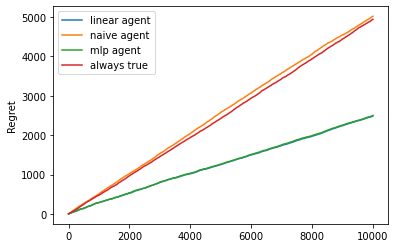

In [ ]:

plt.plot(optimal_rewards - np.cumsum(np.array(linear_rewards)), label = "linear agent")
plt.plot(optimal_rewards- np.cumsum(np.array(naive_rewards)), label = "naive agent")
plt.plot(optimal_rewards- np.cumsum(np.array(mlp_rewards)), label = "mlp agent")
plt.plot(optimal_rewards- np.cumsum(np.array(always_true_rewards)), label = "always true")
plt.ylabel("Regret")
plt.legend();

In [ ]:
selected_numbers

tensor([1.0000e+12, 1.0000e+12])

In [ ]:
print("hi")

hi


tensor([1.1159])

In [ ]:
torch.tensor(5)

tensor(5)

In [ ]:
import matplotlib.pyplot as plt

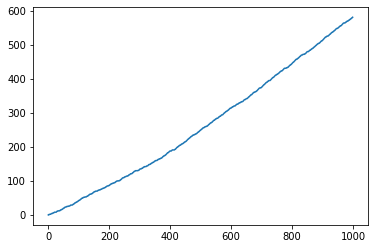

In [ ]:
plt.plot(np.cumsum(np.array(rewards)))

In [ ]:
naive_agent = NaiveDecision()
#linear_agent = LinearMLPDecision(0.9)
linear_agent = LinearDecision(0.9)
mlp_agent = MLPDecision(1e-3)
naive_rewards = []
linear_rewards = []
mlp_rewards = []


def get_reward(hidden_number_is_bigger, actual):
    if hidden_number_is_bigger == actual:
        return 1
    else:
        return 0


In [ ]:
shown_number = 7000



In [ ]:
## naive strategy
hidden_number_is_bigger = naive_agent.decision(shown_number)
naive_rewards.append(get_reward(hidden_number_is_bigger, actual))

In [ ]:
hidden_number_is_bigger = linear_agent.decision(shown_number)
hidden_number_is_bigger

False

In [ ]:
actual = torch.tensor(8) > torch.tensor(shown_number)
linear_agent.update_rule(actual.type(torch.float32))    
linear_rewards.append(get_reward(hidden_number_is_bigger, actual))

In [ ]:
linear_rewards

[0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1]

In [ ]:
naive_rewards = [random.randint(0,1) for _ in range(len(linear_rewards))]

In [ ]:
optimal_rewards = np.cumsum(np.ones_like(linear_rewards))

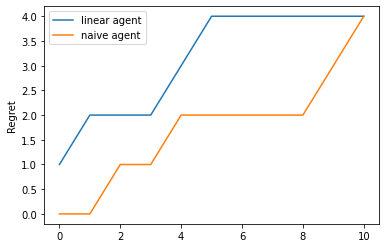

In [ ]:
plt.plot(optimal_rewards - np.cumsum(np.array(linear_rewards)), label = "linear agent")
naive_rewards = [random.randint(0,1) for _ in range(len(linear_rewards))]
plt.plot(optimal_rewards- np.cumsum(np.array(naive_rewards)), label = "naive agent")
#plt.plot(-optimal_rewards, label = "optimal")
#plt.plot(optimal_rewards- np.cumsum(np.array(mlp_rewards)), label = "mlp agent")
plt.ylabel("Regret")
plt.legend();

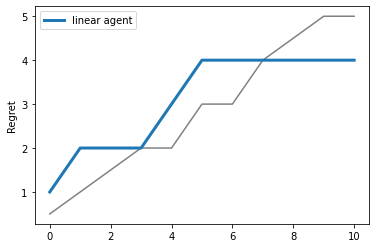

In [ ]:


guesses = []
for _ in range(1000):
    naive_rewards = [random.randint(0,1) for _ in range(len(linear_rewards))]
    guesses.append(optimal_rewards- np.cumsum(np.array(naive_rewards)))
plt.plot(np.median(np.array(guesses),0), color = 'gray')
plt.plot(optimal_rewards - np.cumsum(np.array(linear_rewards)), label = "linear agent", lw = 3)
#plt.plot(optimal_rewards- np.cumsum(np.array(mlp_rewards)), label = "mlp agent")
plt.ylabel("Regret")
plt.legend();

In [ ]:
np.array(guesses)

(1000, 11)

In [ ]:
|





#selected_numbers = 3*torch.randn(2)+5
selected_numbers = torch.from_numpy(datasets.make_blobs(n_samples=1,)[0]).type(torch.float32)[0]
coin_flip = random.randint(0,1)
shown_number = selected_numbers[coin_flip]
hidden_number = selected_numbers[~coin_flip]

actual = hidden_number > shown_number

## naive strategy
hidden_number_is_bigger = naive_agent.decision(shown_number)
naive_rewards.append(get_reward(hidden_number_is_bigger, actual))

# linear strategy
hidden_number_is_bigger = linear_agent.decision(shown_number)
linear_agent.update_rule(actual.type(torch.float32))    
linear_rewards.append(get_reward(hidden_number_is_bigger, actual))

# mlp strategy
hidden_number_is_bigger = mlp_agent.decision(shown_number)
mlp_agent.update_rule(actual.type(torch.float32))    
mlp_rewards.append(get_reward(hidden_number_is_bigger, actual))


    


optimal_rewards = np.cumsum(np.ones_like(linear_rewards))